<h1><font color='#306998'><center>Extreme Gradient Boosting</center></font></h1>

---

## Implementation
We will use XGBClassifier from XGBoost library to predict future prices of the security by creating a custom list of features from the raw price series. 

**Import Libraries**

In [1]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data manipulation 
import pandas as pd
import numpy as np

# Quant library
from quantmod.timeseries import *
from quantmod.indicators import *

# Plotting
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (train_test_split, 
                                    RandomizedSearchCV, 
                                    TimeSeriesSplit, 
                                    )
# Classifier
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance, to_graphviz

# metrics
from sklearn.metrics import (accuracy_score,
                             auc,
                             roc_curve, 
                             RocCurveDisplay,
                             ConfusionMatrixDisplay,
                             confusion_matrix
                            )


from sklearn.metrics import (classification_report, 
                             confusion_matrix 
                            )

### Retrieve Data
We will retrieve the adjusted closed price of SPY from locally stored data.

In [2]:
url = "https://raw.githubusercontent.com/kannansingaravelu/datasets/main/spy.csv"
df = pd.read_csv(url)

# Save locally
df.to_csv("../data/raw/spy.csv", index=False)

print("File downloaded and saved to ../data/spy.csv")
df

File downloaded and saved to ../data/spy.csv


,Date,Open,High,Low,Close,Adj Close,Volume
0,1999-12-31,146.843750,147.500000,146.250000,146.875000,100.376900,3172700
1,2000-01-03,148.250000,148.250000,143.875000,145.437500,99.394493,8164300
2,2000-01-04,143.531250,144.062500,139.640625,139.750000,95.507530,8089800
3,2000-01-05,139.937500,141.531250,137.250000,140.000000,95.678391,12177900
4,2000-01-06,139.625000,141.500000,137.750000,137.750000,94.140717,6227200
...,...,...,...,...,...,...,...
5109,2020-04-23,280.489990,283.940002,278.750000,279.079987,279.079987,104709700
5110,2020-04-24,280.730011,283.700012,278.500000,282.970001,282.970001,85166000
5111,2020-04-27,285.119995,288.269989,284.619995,287.049988,287.049988,77896600
5112,2020-04-28,291.019989,291.399994,285.399994,285.730011,285.730011,105270000


### EDA of Original dataset

In [3]:
# Descriptive statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,5114.0,1.598580e+02,6.067946e+01,6.795000e+01,1.157525e+02,1.370850e+02,2.017675e+02,3.377900e+02
High,5114.0,1.607984e+02,6.083027e+01,7.000000e+01,1.166625e+02,1.379550e+02,2.027875e+02,3.390800e+02
Low,5114.0,1.588300e+02,6.051593e+01,6.710000e+01,1.149025e+02,1.361100e+02,2.007225e+02,3.374800e+02
Close,5114.0,1.598609e+02,6.069407e+01,6.811000e+01,1.158975e+02,1.369450e+02,2.018725e+02,3.383400e+02
Adj Close,5114.0,1.363339e+02,6.792366e+01,5.418443e+01,8.741249e+01,1.064888e+02,1.829516e+02,3.363621e+02
Volume,5114.0,1.127593e+08,9.870486e+07,1.436600e+06,4.821255e+07,8.357545e+07,1.515544e+08,8.710263e+08


### Cleaning & Imputation

Data is already cleaned. However, NaN values from derived features should be treated. 

In [4]:
# Check for missing values
df.isnull().sum()

Date         0
Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
dtype: int64

### Feature Specification
Features or Predictors are also known as an independent variable which are used to determine the value of the target variable. We will use raw price to derive list of custom features.

In [5]:
# use quantmod to use indicators
features_list = []
for r in range(5, 50 , 5):
    df['SMA_'+str(r)] = SMA(df['Adj Close'], r)
    df['EMA_'+str(r)] = EMA(df['Adj Close'], r)
    features_list.append('SMA_'+str(r))
    features_list.append('EMA_'+str(r))

df['ATR'] = ATR(df)
df['BBANDS_L'] = BBands(df['Adj Close'],5,2)[0]
df['BBANDS_M'] = BBands(df['Adj Close'],5,2)[1]
df['BBANDS_U'] = BBands(df['Adj Close'],5,2)[2]
df['RSI'] = RSI(df['Adj Close'], 14)
df['MACD'] = MACD(df['Adj Close'], 5, 12, 26)[0]

# Drop NaN values
df.dropna(inplace=True)
df

,Date,Open,High,Low,Close,Adj Close,Volume,SMA_5,EMA_5,SMA_10,...,SMA_40,EMA_40,SMA_45,EMA_45,ATR,BBANDS_L,BBANDS_M,BBANDS_U,RSI,MACD
44,2000-03-06,140.812500,141.343750,138.750000,139.750000,95.507530,11967100,95.033429,95.007774,93.633495,...,96.217661,95.852846,96.306766,96.085670,2.891741,93.095617,95.033429,96.971241,50.576360,-0.603398
45,2000-03-07,140.000000,140.156250,135.218750,137.046875,93.660210,20062000,94.980046,94.558586,93.775521,...,96.068965,95.745888,96.157506,95.980215,3.000000,92.881788,94.980046,97.078304,41.164487,-0.626623
46,2000-03-08,136.468750,137.843750,135.031250,136.875000,93.542732,11808500,94.766475,94.219968,93.796876,...,95.908789,95.638417,96.027467,95.874238,3.037946,92.295848,94.766475,97.237102,44.917778,-0.647050
47,2000-03-09,137.250000,140.875000,136.125000,140.875000,96.276367,5500900,95.086819,94.905434,94.279536,...,95.846855,95.669537,96.044552,95.891722,3.218750,92.282852,95.086819,97.890787,55.361687,-0.437612
48,2000-03-10,140.187500,142.000000,139.531250,140.125000,95.763870,7924600,94.950142,95.191580,94.744048,...,95.796668,95.674138,96.046452,95.886163,3.091518,92.424981,94.950142,97.475303,60.953175,-0.309419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5109,2020-04-23,280.489990,283.940002,278.750000,279.079987,279.079987,104709700,279.890002,278.672024,279.396005,...,268.434096,276.323438,274.331356,277.899923,8.602143,270.058661,279.890002,289.721344,67.266486,2.598033
5110,2020-04-24,280.730011,283.700012,278.500000,282.970001,282.970001,85166000,279.156000,280.104683,279.873004,...,268.114076,276.647660,273.175573,278.120361,8.395001,271.547767,279.156000,286.764233,71.968147,3.009828
5111,2020-04-27,285.119995,288.269989,284.619995,287.049988,287.049988,77896600,280.247998,282.419785,281.012003,...,267.927123,277.155091,272.187117,278.508606,7.428571,269.840615,280.247998,290.655381,66.666651,3.623628
5112,2020-04-28,291.019989,291.399994,285.399994,285.730011,285.730011,105270000,282.785999,283.523193,281.206003,...,267.388297,277.573380,271.413668,278.822580,7.130713,275.423680,282.785999,290.148317,65.232179,3.957934


In [6]:
# Convert to NumPy
X = df.drop(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close'],axis=1)
X.head(2)

,Volume,SMA_5,EMA_5,SMA_10,EMA_10,SMA_15,EMA_15,SMA_20,EMA_20,SMA_25,...,SMA_40,EMA_40,SMA_45,EMA_45,ATR,BBANDS_L,BBANDS_M,BBANDS_U,RSI,MACD
44,11967100,95.033429,95.007774,93.633495,94.527836,94.004034,94.574757,94.703468,94.791962,95.099208,...,96.217661,95.852846,96.306766,96.085670,2.891741,93.095617,95.033429,96.971241,50.576360,-0.603398
45,20062000,94.980046,94.558586,93.775521,94.370086,93.892270,94.460438,94.521402,94.684176,95.030441,...,96.068965,95.745888,96.157506,95.980215,3.000000,92.881788,94.980046,97.078304,41.164487,-0.626623


### Target or Label Definition

Label or the target variable is also known as the dependent variable. Here, the target variable is whether the underlying price will close up or down on the next trading day. If the tomorrow’s closing price is greater than 99.50% of today’s closing price, then we will buy the underlying, else do nothing. 

In [7]:
# Define Target
df['Target'] = np.where(lead(df['Adj Close'])>0.995 * df['Adj Close'],1,0)  
df.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume,SMA_5,EMA_5,SMA_10,...,EMA_40,SMA_45,EMA_45,ATR,BBANDS_L,BBANDS_M,BBANDS_U,RSI,MACD,Target
44,2000-03-06,140.8125,141.34375,138.75000,139.750000,95.50753,11967100,95.033429,95.007774,93.633495,...,95.852846,96.306766,96.085670,2.891741,93.095617,95.033429,96.971241,50.576360,-0.603398,0
45,2000-03-07,140.0000,140.15625,135.21875,137.046875,93.66021,20062000,94.980046,94.558586,93.775521,...,95.745888,96.157506,95.980215,3.000000,92.881788,94.980046,97.078304,41.164487,-0.626623,1


In [8]:
df['Target'].sum()

np.int64(3858)

In [9]:
# Define label or target 
y = df['Target']
y

44      0
45      1
46      1
47      0
48      0
       ..
5109    1
5110    1
5111    1
5112    1
5113    0
Name: Target, Length: 5070, dtype: int64

**Split Data**

In [10]:
# Splitting the datasets into training and testing data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Output the train and test data size
print(f"Train and Test Size {len(X_train)}, {len(X_test)}")

Train and Test Size 4056, 1014


**Feature Scaling**

In [11]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Class Weights**

In [12]:
# class weight function
def cwts(dfs):
    c0, c1 = np.bincount(dfs)
    w0=(1/c0)*(len(df))/2 
    w1=(1/c1)*(len(df))/2 
    return {0: w0, 1: w1}

**DMatrix**

In [13]:
# Use DMatrix from XGBoost
train_weights = [cwts(y_train)[0] if label == 0 else cwts(y_train)[1] for label in y_train]
dtrain = xgb.DMatrix(X_train_scaled, label=y_train, nthread=4, weight=train_weights, feature_names=X_train.columns.to_list())

test_weights = [cwts(y_test)[0] if label == 0 else cwts(y_test)[1] for label in y_test]
dtest = xgb.DMatrix(X_test_scaled, label=y_test, nthread=4, weight=test_weights, feature_names=X_test.columns.to_list())

## Base Model

We will now create and train the XGBoost (Regessor). All the feature and label should have a similar scale and the scaling can be accomplished by using the `StandardScaler` transformer.

### Fit Model

In [14]:
# specify params
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 3,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

# train the model
base_model = xgb.train(
    params, 
    dtrain, 
    num_boost_round=100,
    evals=[(dtrain, 'train'), (dtest, 'eval')],
    # early_stopping_rounds=20,
    # verbose_eval=20
    )

[0]	train-logloss:0.68700	eval-logloss:0.68874
[1]	train-logloss:0.68213	eval-logloss:0.68569
[2]	train-logloss:0.67809	eval-logloss:0.68384
[3]	train-logloss:0.67466	eval-logloss:0.68351
[4]	train-logloss:0.67108	eval-logloss:0.68092
[5]	train-logloss:0.66911	eval-logloss:0.67966
[6]	train-logloss:0.66660	eval-logloss:0.68021
[7]	train-logloss:0.66389	eval-logloss:0.67909
[8]	train-logloss:0.66139	eval-logloss:0.67490
[9]	train-logloss:0.65962	eval-logloss:0.67559
[10]	train-logloss:0.65788	eval-logloss:0.67219
[11]	train-logloss:0.65621	eval-logloss:0.66939
[12]	train-logloss:0.65434	eval-logloss:0.66722
[13]	train-logloss:0.65314	eval-logloss:0.66477
[14]	train-logloss:0.65198	eval-logloss:0.66166
[15]	train-logloss:0.65091	eval-logloss:0.66838
[16]	train-logloss:0.64984	eval-logloss:0.66478
[17]	train-logloss:0.64899	eval-logloss:0.67479
[18]	train-logloss:0.64800	eval-logloss:0.67431
[19]	train-logloss:0.64713	eval-logloss:0.67687
[20]	train-logloss:0.64625	eval-logloss:0.69117
[2

### Predict Model

In [15]:
# get probabilities 
y_proba = base_model.predict(dtest)
# get predictions
y_pred = np.round(y_proba)

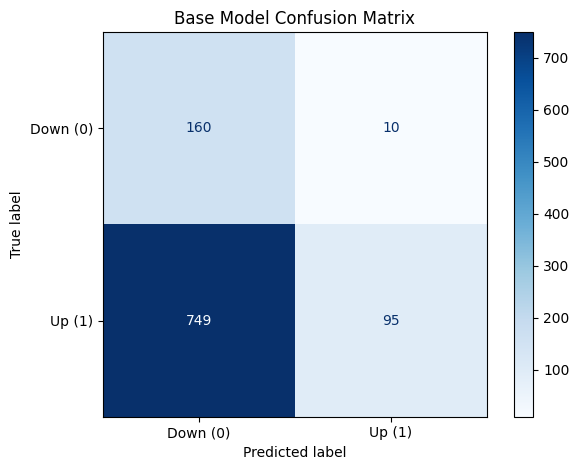

<Figure size 640x480 with 0 Axes>

In [16]:
# Confusion Matrix - Base Model
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Down (0)', 'Up (1)'])
disp.plot(cmap='Blues')
plt.title('Base Model Confusion Matrix')
plt.tight_layout()
plt.show()

# Save to reports folder
plt.savefig("../reports/base_model_confusion_matrix.png", dpi=300)

In [17]:
# Classification report - Base Model
print(f"\n Base Model Classification Report:")
print(classification_report(y_test, y_pred))
    


 Base Model Classification Report:
              precision    recall  f1-score   support

           0       0.18      0.94      0.30       170
           1       0.90      0.11      0.20       844

    accuracy                           0.25      1014
   macro avg       0.54      0.53      0.25      1014
weighted avg       0.78      0.25      0.22      1014



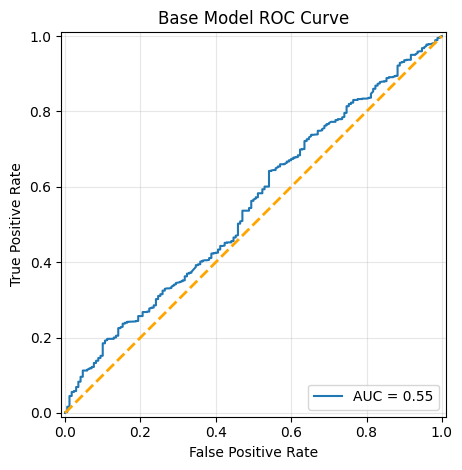

<Figure size 640x480 with 0 Axes>

In [18]:
# ROC Curve - Base Model
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
disp.plot()

plt.title('Base Model ROC Curve')
plt.plot([0, 1], [0, 1], color='orange', lw=2, linestyle='--')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Save to reports folder
plt.savefig("../reports/base_model_ROC_Curve.png", dpi=300)

In [19]:
# Calculate training accuracy
train_preds = np.round(base_model.predict(dtrain))
train_accuracy = accuracy_score(y_train, train_preds)

# Calculate test accuracy
test_preds = np.round(base_model.predict(dtest))
test_accuracy = accuracy_score(y_test, test_preds)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Difference (Training - Test): {train_accuracy - test_accuracy:.4f}")

Training Accuracy: 0.6958
Test Accuracy: 0.2515
Difference (Training - Test): 0.4443


## Hyperparameter Tuning

### RandomizedSearch
The RandomizedSearchCV implements a “fit” and a “score” method and perform randomized search on hyper parameters. The parameters of the estimator used to apply these methods are optimized by cross-validated search over parameter settings. In contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions. 

In [20]:
# Create XGBoost classifier for sklearn API
xgb_classifier = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
)

In [21]:
# Cross-validation
tscv = TimeSeriesSplit(n_splits=5, gap=1)

In [22]:
# Hyperparameter grid
param_grid = {
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 200, 300],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 3, 5, 7]
}

In [23]:
# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_classifier,
    param_distributions=param_grid,
    n_iter=100,
    scoring='roc_auc',
    cv=tscv,
    verbose=1,
    n_jobs=-1
)

In [24]:
# Fit RandomizedSearchCV
random_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


,estimator,"XGBClassifier...ree=None, ...)"
,param_distributions,"{'colsample_bytree': [0.6, 0.7, ...], 'gamma': [0, 0.1, ...], 'learning_rate': [0.01, 0.05, ...], 'max_depth': [3, 4, ...], ...}"
,n_iter,100
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,TimeSeriesSpl...est_size=None)
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [25]:
# Print best parameters
print("\nBest parameters found by RandomizedSearchCV:")
print(random_search.best_params_)
print(f"Best score: {random_search.best_score_:.4f}")


Best parameters found by RandomizedSearchCV:
{'subsample': 0.7, 'n_estimators': 100, 'min_child_weight': 7, 'max_depth': 3, 'learning_rate': 0.01, 'gamma': 0.1, 'colsample_bytree': 0.8}
Best score: 0.6008


## Optimized Model
Let's now train and predict the model with the best search parameter

In [26]:
# Train optimized model with XGBoost using DMatrix
optimized_params = random_search.best_params_.copy()

# Convert parameters for xgb.train()
optimized_params['eta'] = optimized_params.pop('learning_rate')
optimized_params['objective'] = 'binary:logistic'
optimized_params['eval_metric'] = 'logloss'

print("\nTraining optimized XGBoost model with best parameters...")
optimized_model = xgb.train(
    optimized_params,
    dtrain,
    num_boost_round=optimized_params.pop('n_estimators'),
    evals=[(dtrain, 'train'), (dtest, 'eval')],
    # early_stopping_rounds=20,
    # verbose_eval=20
)


Training optimized XGBoost model with best parameters...
[0]	train-logloss:0.69252	eval-logloss:0.69276
[1]	train-logloss:0.69195	eval-logloss:0.69250
[2]	train-logloss:0.69139	eval-logloss:0.69210
[3]	train-logloss:0.69091	eval-logloss:0.69181
[4]	train-logloss:0.69030	eval-logloss:0.69151
[5]	train-logloss:0.68995	eval-logloss:0.69140
[6]	train-logloss:0.68951	eval-logloss:0.69120
[7]	train-logloss:0.68898	eval-logloss:0.69146
[8]	train-logloss:0.68842	eval-logloss:0.69082
[9]	train-logloss:0.68792	eval-logloss:0.69046
[10]	train-logloss:0.68738	eval-logloss:0.68992
[11]	train-logloss:0.68681	eval-logloss:0.68961
[12]	train-logloss:0.68622	eval-logloss:0.68932
[13]	train-logloss:0.68568	eval-logloss:0.68881
[14]	train-logloss:0.68520	eval-logloss:0.68840
[15]	train-logloss:0.68469	eval-logloss:0.68772
[16]	train-logloss:0.68426	eval-logloss:0.68747
[17]	train-logloss:0.68381	eval-logloss:0.68717
[18]	train-logloss:0.68338	eval-logloss:0.68688
[19]	train-logloss:0.68305	eval-logloss:

In [27]:
# Make predictions with basic model
y_proba = optimized_model.predict(dtest)
y_pred = np.round(y_proba)

In [28]:
y_proba[:5]

array([0.536318  , 0.5016298 , 0.509801  , 0.53440744, 0.53288704],
      dtype=float32)

In [29]:
y_proba.shape

(1014,)

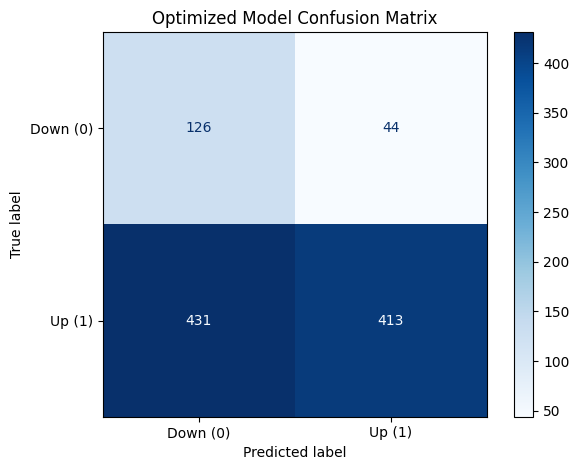

<Figure size 640x480 with 0 Axes>

In [30]:
# Confusion Matrix - Base Model
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Down (0)', 'Up (1)'])
disp.plot(cmap='Blues')
plt.title('Optimized Model Confusion Matrix')
plt.tight_layout()
plt.show()

# Save to reports folder
plt.savefig("../reports/final_model_confusion_matrix.png", dpi=300)

In [31]:
# Print classification report
print("\n Optimized Model Classification Report:")
print(classification_report(y_test, y_pred))


 Optimized Model Classification Report:
              precision    recall  f1-score   support

           0       0.23      0.74      0.35       170
           1       0.90      0.49      0.63       844

    accuracy                           0.53      1014
   macro avg       0.56      0.62      0.49      1014
weighted avg       0.79      0.53      0.59      1014



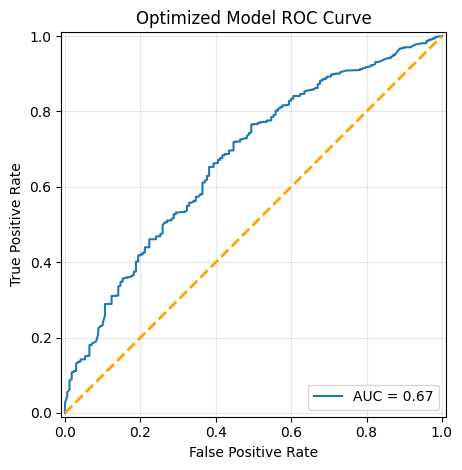

<Figure size 640x480 with 0 Axes>

In [32]:
# ROC Curve - Optimized Model
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
disp.plot()

plt.title('Optimized Model ROC Curve')
plt.plot([0, 1], [0, 1], color='orange', lw=2, linestyle='--')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Save to reports folder
plt.savefig("../reports/final_model_ROC_Curve.png", dpi=300)

In [33]:
# Calculate training accuracy
train_preds = np.round(optimized_model.predict(dtrain))
train_accuracy = accuracy_score(y_train, train_preds)

# Calculate test accuracy
test_preds = np.round(optimized_model.predict(dtest))
test_accuracy = accuracy_score(y_test, test_preds)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Difference (Training - Test): {train_accuracy - test_accuracy:.4f}")

Training Accuracy: 0.6366
Test Accuracy: 0.5316
Difference (Training - Test): 0.1050


**OPTIONAL - EXAMPLE - Save Model**

In [34]:
# Save the optimized model - XGBoost's native format
optimized_model.save_model('ks_xgboost_model.json')
print("\nOptimized model saved as 'ks_xgboost_model.json'")


Optimized model saved as 'ks_xgboost_model.json'


In [35]:
import pickle
import os

# Ensure model directory exists
os.makedirs("../model", exist_ok=True)

# Save model as pickle
with open("../model/model.pkl", "wb") as f:
    pickle.dump(optimized_model, f)

print("Model saved as '../model/model.pkl'")


Model saved as '../model/model.pkl'


**OPTIONAL - EXAMPLE - Load Model**

In [36]:
# OPTIONAL
# Example of loading the model
# loaded_model = xgb.Booster()
# loaded_model.load_model('ks_xgboost_model.json')
# predictions = loaded_model.predict(dtest)

### Feature Importance

Feature Importance refers to techniques that calculate a score for all the input features for a given model where the scores represent the “importance” of each feature. It is calculated as the decrease in node impurity weighted by the probability of reaching that node. The node probability can be calculated by the number of samples that reach the node, divided by the total number of samples. The higher the value the more important the feature. 

The Gain is the most relevant attribute to interpret the relative importance of each feature.

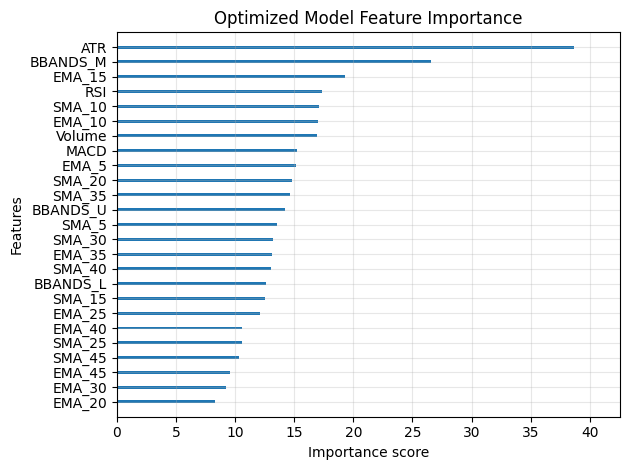

<Figure size 640x480 with 0 Axes>

In [37]:
# Plot the feature importance of the optimized model
plot_importance(optimized_model, importance_type='gain', title='Optimized Model Feature Importance', show_values=False)
plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()

# Save to reports folder
plt.savefig("../reports/final_model_feature_importance.png", dpi=300)